In [1]:
import os
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from GLM_regression import *
%load_ext autoreload
%autoreload 2


plt.rcParams.update({'font.size': 10,
                    'axes.spines.right': False,
                    'axes.spines.top':   False,
                    'legend.frameon':       False,})


# plt.rcParams.update({'font.size': 10,
#                     'axes.spines.right': False,
#                     'axes.spines.top':   False,
#                     'legend.frameon':       False,
#                     'font.sans-serif': 'Helvetica',
#                     'svg.fonttype': 'none'})

In [30]:
filename = "SSTindivsomata_GLM.mat"
# filename = "NDNFindivsomata_GLM.mat"
# filename = "EC_GLM.mat"

filepath = os.path.join("datasets", filename)
reorganized_data, variable_list = load_data(filepath)
GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge')

Best neuron: 8, animal_6
pearson R2 overall: 0.3767958110875292
pearson R2 average: 0.985487334606552


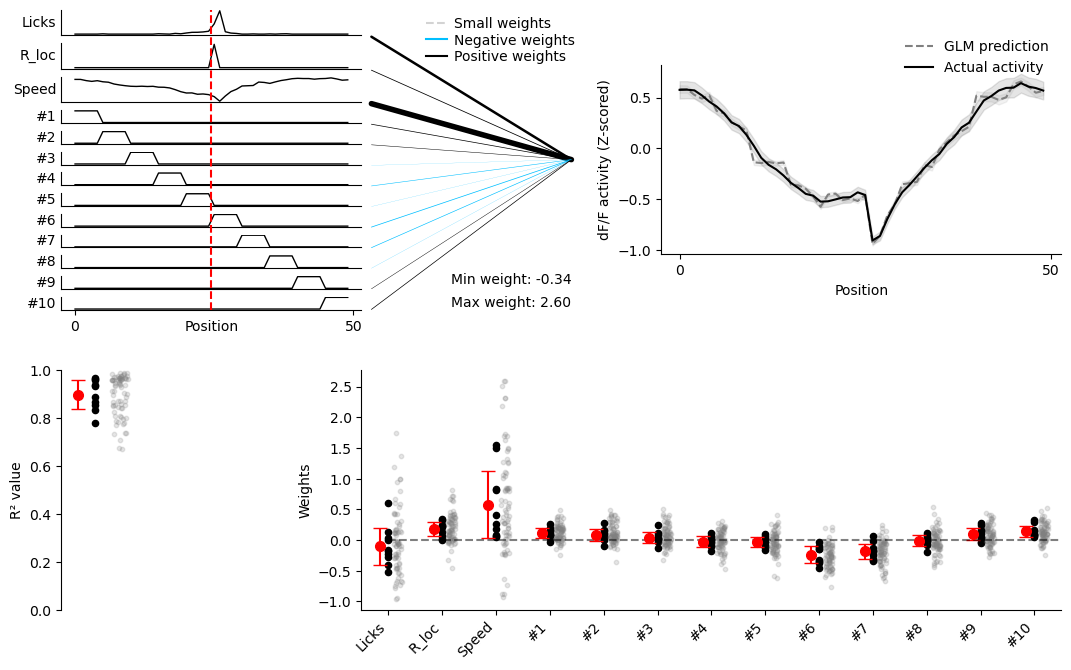

In [31]:
plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename.split('.')[0], sort_by='R2')

In [315]:
# filepath = os.path.join("datasets", filename)
# reorganized_data, variable_list = load_data(filepath)
# GLM_params_nolicks = fit_GLM(reorganized_data, quintile=None, regression='ridge')

In [316]:
# filepath = os.path.join("datasets", filename)
# reorganized_data, variable_list = load_data(filepath)
# GLM_params_noRlocs = fit_GLM(reorganized_data, quintile=None, regression='ridge')

In [8]:
# plot_R2_distribution([GLM_params,GLM_params_nolicks, GLM_params_noRlocs], title=filename)

Best neuron: 0, animal_1
pearson R2 overall: 0.03177180051627401
pearson R2 average: 0.8933778759100373


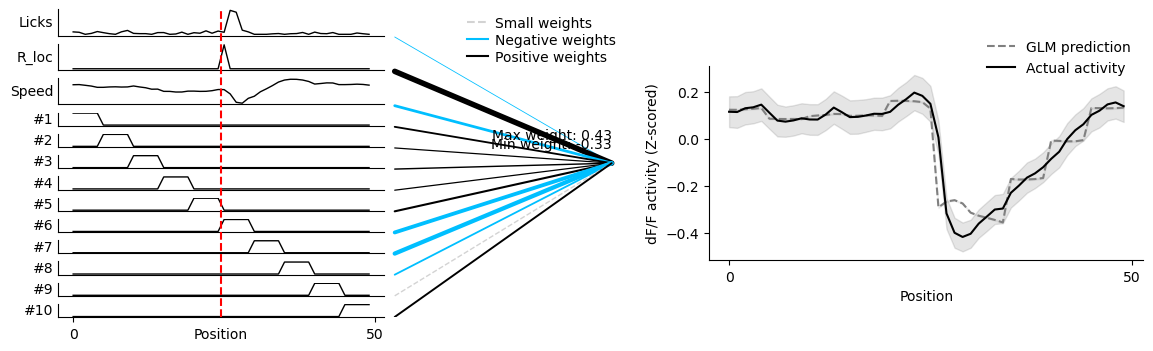

In [288]:
plot_example_neuron(reorganized_data, GLM_params, variable_list, animal='animal_1', neuron=0)

In [92]:
# datasets = ["SSTindivsomata_GLM.mat", "NDNFindivsomata_GLM.mat", "EC_GLM.mat"]

# fig = plt.figure(figsize=(18, 8))
# axes = gs.GridSpec(nrows=len(datasets), ncols=4, hspace=0.6, wspace=0.3)

# for i,filename in enumerate(datasets):
#     filepath = os.path.join("datasets", filename)
#     reorganized_data, variable_list = load_data(filepath)
#     GLM_params_start = fit_GLM(reorganized_data, quintile=1, regression='ridge')
#     GLM_params_end = fit_GLM(reorganized_data, quintile=5, regression='ridge')
#     delta_weights = calculate_delta_weights(reorganized_data, GLM_params_start, GLM_params_end)

#     ax = fig.add_subplot(axes[i, 1])
#     plot_GLM_summary_data(GLM_params_start, variable_list, ax=ax)
#     ax.set_title('First quintile')
    
#     ax = fig.add_subplot(axes[i, 2])
#     plot_GLM_summary_data(GLM_params_end, variable_list, ax=ax)
#     ax.set_title('Last quintile')

#     ax = fig.add_subplot(axes[i, 3])
#     plot_R2_distribution(GLM_params_start, GLM_params_end, ax=ax)
#     ax.set_xlim([0.5, 3.5])

#     ax = fig.add_subplot(axes[i, 0])
#     plot_delta_weights_summary(delta_weights, variable_list, model_name=filepath.split('.')[0], ax=ax)

#     if i == 0:
#         ax.scatter([],[], color='gray', label='Neurons', s=20)
#         ax.scatter([],[], color='black', label='Animal avg', s=20)
#         ax.scatter([],[], color='red', label='Overall avg', s=20)
#         ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False, handletextpad=0.5, labelspacing=0.2, borderpad=0)

# fig.savefig('figures/delta_weights_summary.png', dpi=300)

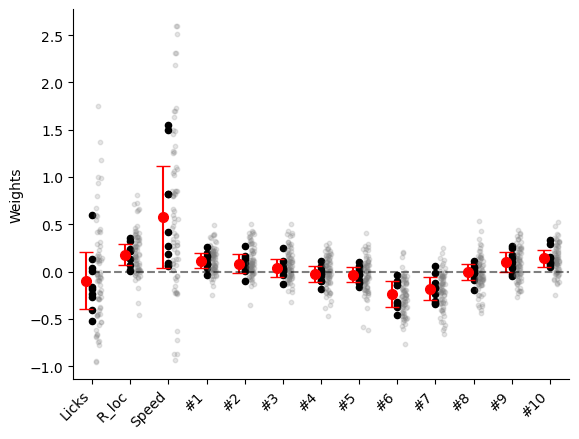

In [6]:
plot_GLM_summary_data(GLM_params, variable_list, ax=None)

Average residual magnitude: 0.05


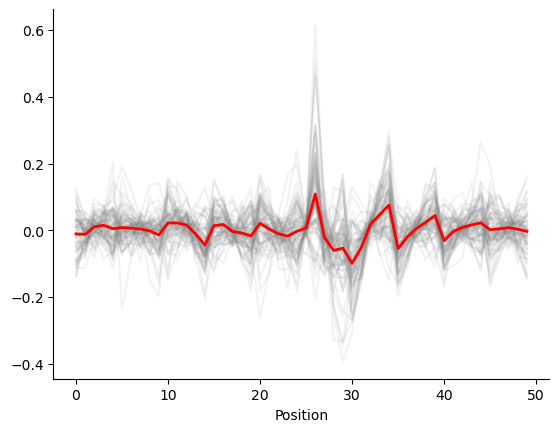

In [133]:
residual_activity = compute_residual_activity(GLM_params, reorganized_data)

residuals = np.array([np.mean(residual_activity[animal][neuron], axis=1) for animal in residual_activity for neuron in residual_activity[animal]])

# animal = 'animal_5'
# residuals = np.array([np.mean(residual_activity[animal][neuron], axis=1) for neuron in residual_activity[animal]])


print(f"Average residual magnitude: {np.mean(np.abs(residuals)):.2f}")
plt.plot(residuals.T, c='gray', alpha=0.1)   
plt.plot(np.mean(residuals, axis=0), c='r', lw=2) 
plt.xlabel('Position')
plt.show()

In [6]:
# filename = "SSTindivsomata_GLM.mat"
# filename = "NDNFindivsomata_GLM.mat"
filename = "EC_GLM.mat"

filepath = os.path.join("datasets", filename)
reorganized_data, variable_list = load_data(filepath)

quintile = 1
GLM_params_1 = fit_GLM(reorganized_data, quintile=quintile, regression='ridge')
vars_to_remove = variable_list.copy()[1:]
vars_to_remove.remove('Speed')
filtered_GLM_params_1 = remove_variables_from_glm(GLM_params_1, vars_to_remove, variable_list)
residual_activity_1, avg_residuals_1 = compute_residual_activity(filtered_GLM_params_1, reorganized_data, quintile=quintile)

quintile = 5
GLM_params_5 = fit_GLM(reorganized_data, quintile=quintile, regression='ridge')
vars_to_remove = variable_list.copy()[1:]
vars_to_remove.remove('Speed')
filtered_GLM_params_5 = remove_variables_from_glm(GLM_params_5, vars_to_remove, variable_list)
residual_activity_5, avg_residuals_5 = compute_residual_activity(filtered_GLM_params_5, reorganized_data, quintile=quintile)

sorting_idx_5 = np.argsort(np.argmax(avg_residuals_5, axis=1))
avg_residuals_1 = avg_residuals_1[sorting_idx_5]
avg_residuals_5 = avg_residuals_5[sorting_idx_5]

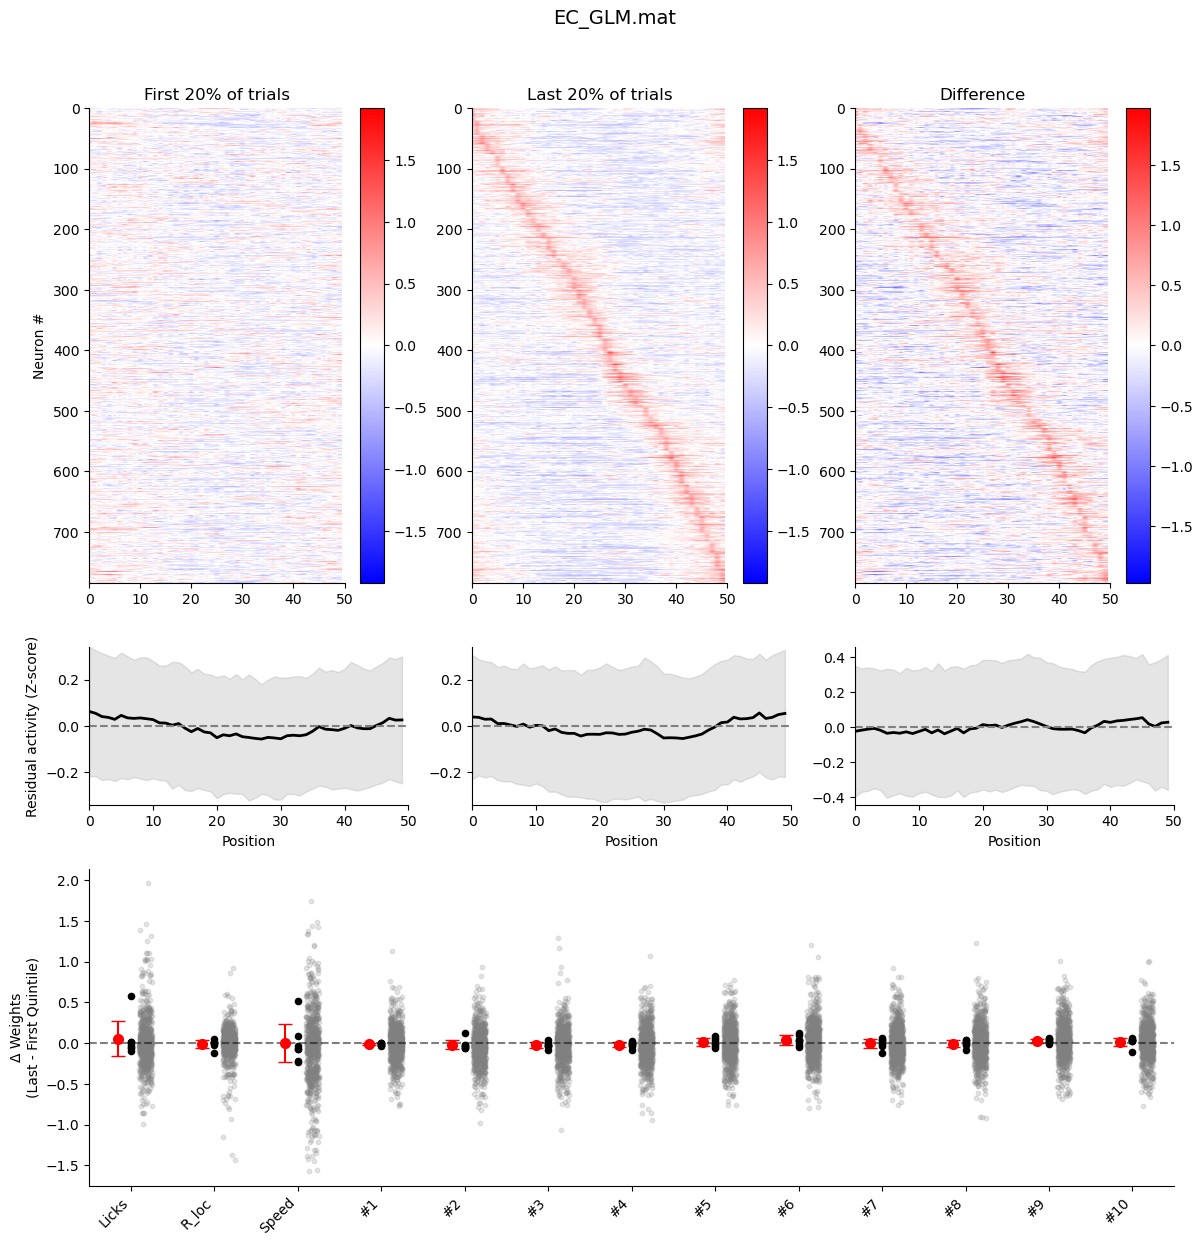

In [7]:
fig = plt.figure(figsize=(14, 14))
fig.suptitle(filename, fontsize=14, y=0.95)
axes = gs.GridSpec(nrows=3, ncols=3, hspace=0.2, wspace=0.2, height_ratios=[3,1,2])

vmax = np.max([np.abs(avg_residuals_1), np.abs(avg_residuals_5)])
plot_scale = np.max([np.abs(np.mean(avg_residuals_1, axis=0))+np.std(avg_residuals_1, axis=0), np.abs(np.mean(avg_residuals_5, axis=0))+np.std(avg_residuals_5, axis=0)])

# Heatmap 1
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(avg_residuals_1, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('First 20% of trials')
ax.set_ylabel('Neuron #')

# Plot avg 1
ax = fig.add_subplot(axes[1,0])
ax.plot(np.mean(avg_residuals_1, axis=0), c='k', lw=2)
std = np.std(avg_residuals_1, axis=0)
sem = std / np.sqrt(avg_residuals_1.shape[0])
ax.fill_between(np.arange(50), np.mean(avg_residuals_1, axis=0)-std, np.mean(avg_residuals_1, axis=0)+std, color='gray', alpha=0.2)
ax.hlines(0, 0, 50, color='gray', linestyle='--')
ax.set_xlim([0, 50])
ax.set_ylim([-plot_scale, plot_scale])
ax.set_ylabel('Residual activity (Z-score)')
ax.set_xlabel('Position')

# Heatmap 2
ax = fig.add_subplot(axes[0,1])
vmax = np.max(np.abs(avg_residuals_5))
im = ax.imshow(avg_residuals_5, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('Last 20% of trials')

# Plot avg 2
ax = fig.add_subplot(axes[1,1])
ax.plot(np.mean(avg_residuals_5, axis=0), c='k', lw=2)
std = np.std(avg_residuals_5, axis=0)
sem = std / np.sqrt(avg_residuals_5.shape[0])
ax.fill_between(np.arange(50), np.mean(avg_residuals_5, axis=0)-std, np.mean(avg_residuals_5, axis=0)+std, color='gray', alpha=0.2)
ax.set_xlim([0, 50])
ax.set_ylim([-plot_scale, plot_scale])
ax.set_xlabel('Position')
ax.hlines(0, 0, 50, color='gray', linestyle='--')

# Plot delta
delta_residuals = avg_residuals_5 - avg_residuals_1
ax = fig.add_subplot(axes[0,2])
vmax = np.max(np.abs(delta_residuals))
im = ax.imshow(delta_residuals, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('Difference')

ax = fig.add_subplot(axes[1,2])
ax.plot(np.mean(delta_residuals, axis=0), c='k', lw=2)
std = np.std(delta_residuals, axis=0)
sem = std / np.sqrt(delta_residuals.shape[0])
ax.fill_between(np.arange(50), np.mean(delta_residuals, axis=0)-std, np.mean(delta_residuals, axis=0)+std, color='gray', alpha=0.2)
ax.set_xlim([0, 50])
ax.set_xlabel('Position')
ax.hlines(0, 0, 50, color='gray', linestyle='--')

ax = fig.add_subplot(axes[2,:])
delta_weights = calculate_delta_weights(reorganized_data, GLM_params_1, GLM_params_5)
plot_delta_weights_summary(delta_weights, variable_list, model_name=None, save=False, ax=ax)

fig.savefig(f'figures/{filename.split(".")[0]}_residuals.png', dpi=300)
fig.savefig(f'figures/{filename.split(".")[0]}_residuals.svg', dpi=300)


['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10', 'R_loc']


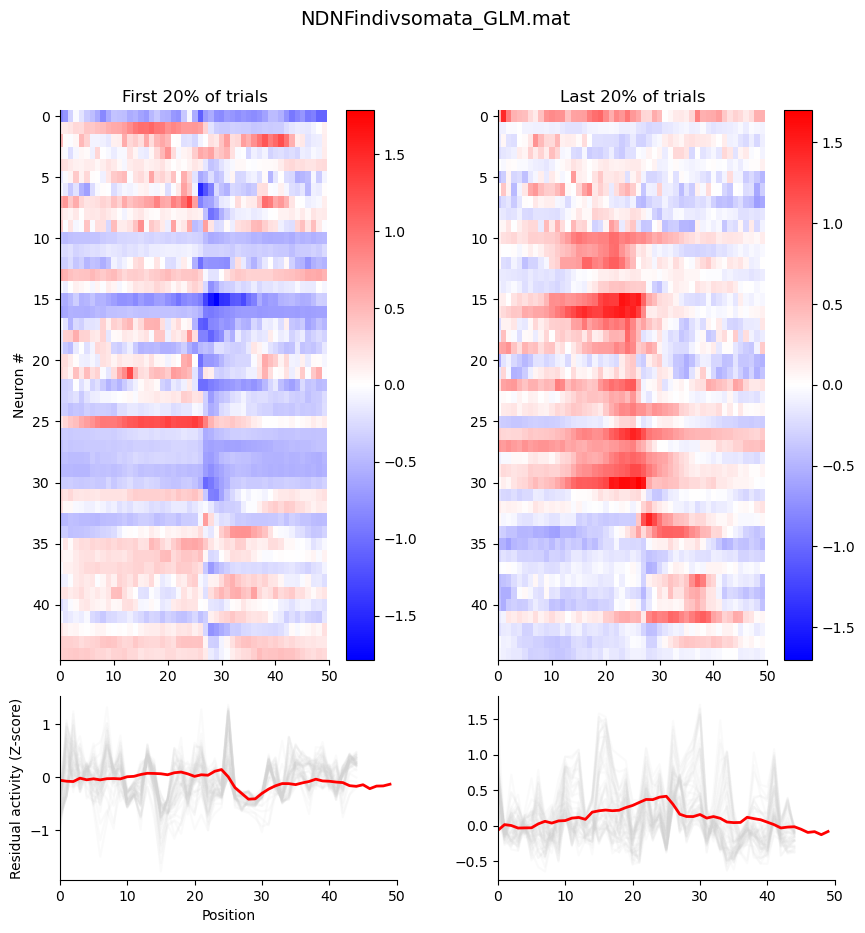

In [76]:
def compute_velocity_corrected_residuals(residual_activity, reorganized_data):
    velocity_corrected_residuals = {}
    bin_size_cm = 180/50
    for animal in reorganized_data:
        velocity_corrected_residuals[animal] = {}
        for i,neuron_data in enumerate(reorganized_data[animal]):
            neuron_data = neuron_data[:,:,~np.isnan(neuron_data).any(axis=(0,1))]
            velocity = neuron_data[:,3]
            neuron_residual = residual_activity[animal][i] / velocity * bin_size_cm
            velocity_corrected_residuals[animal][i] = neuron_residual
    return velocity_corrected_residuals


fig = plt.figure(figsize=(10, 10))
fig.suptitle(filename, fontsize=14)
axes = gs.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace=0.3, height_ratios=[3, 1])


vars_to_remove = variable_list[4:] + ['R_loc']
print(vars_to_remove)
filtered_GLM_params = remove_variables_from_glm(GLM_params, vars_to_remove, variable_list)
residual_activity = compute_residual_activity(filtered_GLM_params, reorganized_data)
# residual_activity = compute_velocity_corrected_residuals(residual_activity, reorganized_data)

ax = fig.add_subplot(axes[0,1])
avg_residuals = []
quintile = 5
for animal in residual_activity:
    for neuron in residual_activity[animal]:
        num_trials = residual_activity[animal][neuron].shape[1]
        start_idx,end_idx = get_quintile_indices(num_trials, quintile)
        avg_residuals.append(np.mean(residual_activity[animal][neuron][:,start_idx:end_idx], axis=1))
avg_residuals = np.array(avg_residuals)

sorting_idx_5 = np.argsort(np.argmax(avg_residuals, axis=1))
sorted_avg_residuals = avg_residuals[sorting_idx_5]

vmax = np.max(np.abs(sorted_avg_residuals))
im = ax.imshow(sorted_avg_residuals, aspect='auto', cmap='bwr', interpolation='none', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('Last 20% of trials')
ax = fig.add_subplot(axes[1,1])
ax.plot(sorted_avg_residuals, c='lightgray', alpha=0.1)
ax.plot(np.mean(sorted_avg_residuals, axis=0), c='r', lw=2)
ax.set_xlim([0, 50])


ax = fig.add_subplot(axes[0,0])
avg_residuals = []
quintile = 1
for animal in residual_activity:
    for neuron in residual_activity[animal]:
        num_trials = residual_activity[animal][neuron].shape[1]
        start_idx,end_idx = get_quintile_indices(num_trials, quintile)
        avg_residuals.append(np.mean(residual_activity[animal][neuron][:,start_idx:end_idx], axis=1))
avg_residuals = np.array(avg_residuals)

sorted_avg_residuals = avg_residuals[sorting_idx_5]

vmax = np.max(np.abs(sorted_avg_residuals))
im = ax.imshow(sorted_avg_residuals, aspect='auto', cmap='bwr', interpolation='none', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_ylabel('Neuron #')
ax.set_title('First 20% of trials')
ax = fig.add_subplot(axes[1,0])
ax.plot(sorted_avg_residuals, c='lightgray', alpha=0.1)
ax.plot(np.mean(sorted_avg_residuals, axis=0), c='r', lw=2)
ax.set_xlim([0, 50])
ax.set_ylabel('Residual activity (Z-score)')
ax.set_xlabel('Position')
plt.show()


# fig.savefig(f'figures/activity_residuals_heatmap_{filename}.png', dpi=300)
# fig.savefig(f'figures/activity_residuals_heatmap_corrected_dwelltime_{filename}.png', dpi=300)